In [1]:


import pandas as pd
from sklearn.metrics import *

from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import matplotlib.pylab as pl

# print the JS visualization code to the notebook
shap.initjs()



C:\Users\Jan\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv(r'standardized_iqr_OD.csv', index_col=0)
print(df.info())
col = 'CAMPAIGNPRODUCTIONTIME'[:20]
predict_CPT = False
if predict_CPT: 
    col = 'CAMPAIGNPRODUCTIONTIME'[:20]
    '''try:
    del df['isOutlier']
    except:
        pass'''
else: 
    col = 'isOutlier'


df.rename(columns=lambda x: x[:20], inplace=True)
X = df.loc[:, df.columns != col]
Y = df[col]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)
# Just making sure indexing is not a problem!
#X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train).reshape((y_train.shape[0],1)), np.array(y_test).reshape((y_test.shape[0],1))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6682 entries, 0 to 6681
Data columns (total 65 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   CAMPAIGNPRODUCTIONTIME                                        6682 non-null   float64
 1   CHANNELS                                                      6682 non-null   float64
 2   SOPHISTICATION                                                6682 non-null   float64
 3   NUMOFFORMATS                                                  6682 non-null   float64
 4   NUMBEROFDESIGNS                                               6682 non-null   float64
 5   AVERAGENUMBEROFSIZESPERDESIGN                                 6682 non-null   float64
 6   AVERAGENUMBEROFLANGUAGESPERDESIGN                             6682 non-null   float64
 7   AVERAGENUMBEROFCONTENTVARIATIONSPERLOCALIZATION               6682 no

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


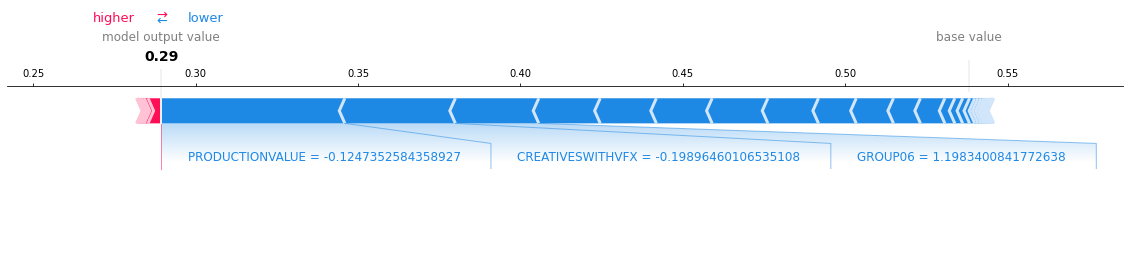

In [3]:
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=Y), 100)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], matplotlib=True)

In [4]:
shap.force_plot(explainer.expected_value, shap_values[0:1000,:], X.iloc[0:1000,:])

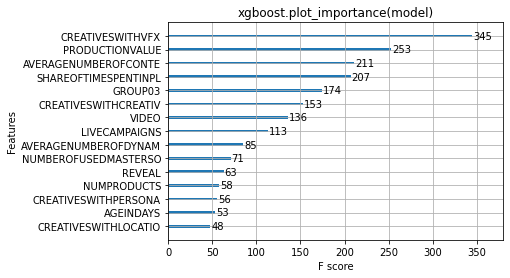

In [5]:
xgboost.plot_importance(model, max_num_features=15)
pl.title("xgboost.plot_importance(model)")
pl.show()

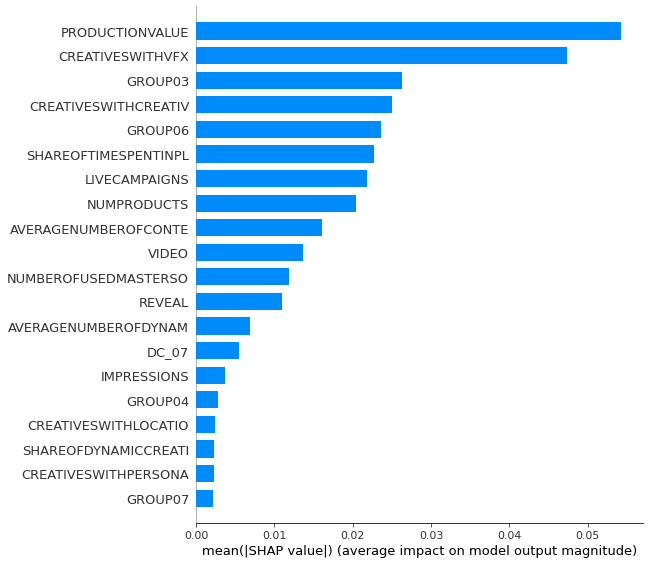

In [6]:
shap.summary_plot(shap_values, X, plot_type="bar")

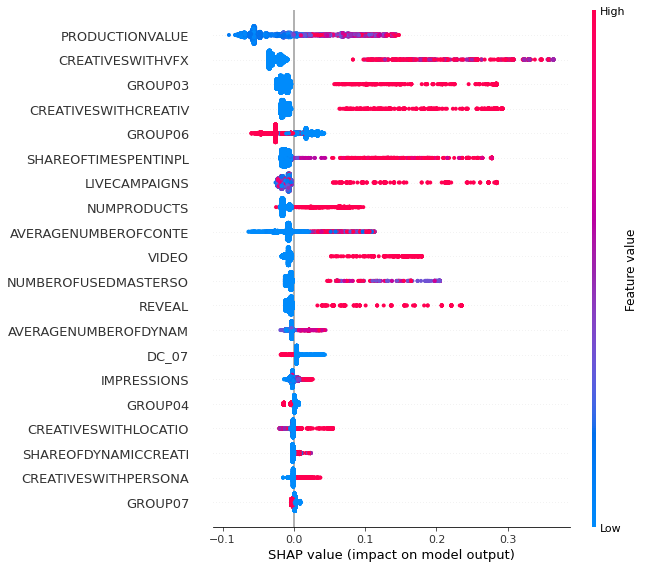

In [7]:
shap.summary_plot(shap_values, X)

# Simple supervised clustering

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca50 = PCA(n_components=12).fit_transform(shap_values)
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values)

In [9]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)

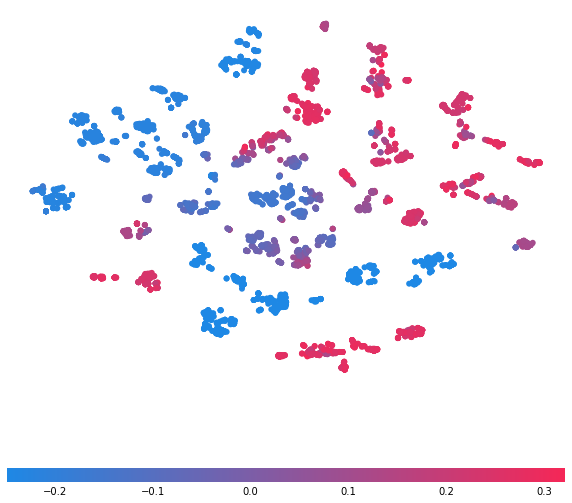

In [10]:
f = pl.figure(figsize=(10,10))
pl.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=shap_values.sum(1).astype(np.float64),
           linewidth=0, alpha=1., cmap=red_blue_solid)
cb = pl.colorbar(label="", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

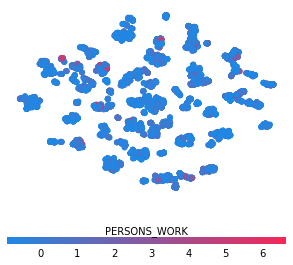

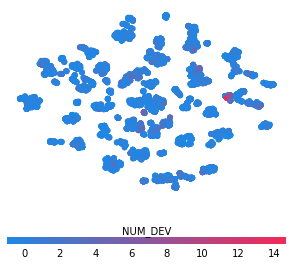

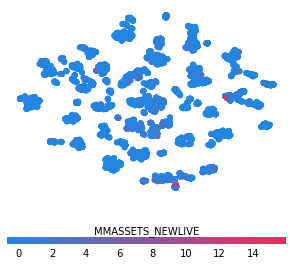

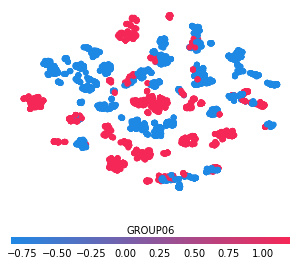

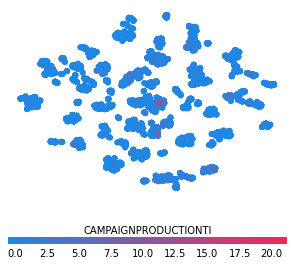

In [11]:
for feature in ['PERSONS_WORK', 'NUM_DEV', 'MMASSETS_NEWLIVE', 'GROUP06', 'CAMPAIGNPRODUCTIONTIME'[:20]]:
    f = pl.figure(figsize=(5,5))
    pl.scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=X[feature].values.astype(np.float64),
               linewidth=0, alpha=1., cmap=red_blue_solid)
    cb = pl.colorbar(label=feature, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    pl.gca().axis("off")
    pl.show()